# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

# The environment is statically defined by its HMM matrices : 
from simulate.hmm_weights import behavioural_process

# For the active inference model : 
from simulate.hmm_weights import basic_latent_model

# To make nice plots : 
from simulate.plot_trajectory import plot_training


In [2]:
# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop,generate_synthetic_data

T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
env = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)
    
for k in range(10):
    print("----Trial {}----".format(k))
    o,r,end_trial,t,gt_state = env.reinit_trial()
    print(t,o,r)
    while not(end_trial) :
        action = jax.nn.one_hot(1,9)
        o,r,end_trial,t,gt_state = env.step(action)
        print(t,o,r)
    print("----")
        

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----Trial 0----
0 [Array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] -0.22222221
2 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] 0.0
3 [Array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)] -0.111111134
4 [Array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.33333334
5 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] 0.44444448
6 [Array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)] 0.111111104
7 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.33333334
8 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
9 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.11111112
10 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.11111112
----
----Trial 1----
0 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0

To put all the models we are going to fit in an equal footing, we will assume a discretized action space along the 3 dimensions previously mentionned for all of them. To study the effect of not making this crucial hypothesis, we refer the reader to the Reinforcment Learning part of this study. 

Reward definition : we will assume that agents perceive changes in the level of the gauge as a reward signal.

Here, we will study the following models : 
### Blind models - the action does not depend on the stimuli at all
1. A random action model that selects actions randomly and does not learn
2. A choice kernel model that repeats actions it already performed :  $CK_{t+1}(u) = CK_{t}(u) + \alpha_c (a_t - CK_{t}(u))$ where $a_t$ is 1 if $u$ was selcted and 0.0 otherwise. $P_t(u) = \sigma(\beta_c CK_{t})$
### Stateless models - the action does not depend on the level of the gauge but only on the reward
3. A Rescorla-Wagner model - stateless that attempts to learn the value of a specific action by updating the perceived reward attached to it : $Q_{t+1}(u) = Q_{t}(u) + \alpha (r_t - Q_{t}(u))$  (Wilson RC, Collins AG. Ten simple rules for the computational modeling of behavioral data. Elife. 2019 Nov 26;8:e49547. doi: 10.7554/eLife.49547. PMID: 31769410; PMCID: PMC6879303.). Actions are selected through a tempered softmax following : $P_t(u) = \sigma(\beta Q_{t})$. The free parameters for this model are $\alpha$ and $\beta$.
4. A mix of the previous 2 models : $P_t(u) = \sigma(\beta Q_{t} + \beta_c CK_{t})$
### Stateful models - the action depends on the level of the gauge as well as the reward
5. A tabular Q-learning agent : $Q_{t+1}(u,s) = Q_{t}(u,s) + \alpha (r_t - Q_{t}(u,s))$ with different learning rates for positive and negative feedbacks $\{\alpha_-,\alpha_+\}$ with a choice temperature $\beta$.
6. A vesion of this agent that takes into account the choice Kernel described previously
### Bayesian Active Inference models - The reward is not taken into account. The level of the gauge is interpreted as an indicator regarding a true (hidden) state of the system
7. A single dimension model ("How far am I from my goal ?") with various subcategories of models : 
    - A naive q learning like model  with low amounts of states
    - A more advanced model that features the ability to generalize between states
    - An even more advanced model that also features the ability to generalize between actions
8. A bidimensionnal model ("Where am I in the grid ? Where is my goal ?")




Because we have a much more complex intuition behind what is happening but with a pretty hard-to-derive likelihood function, we should look at Simulation Based Inference (see https://elifesciences.org/articles/56261#s4,https://astroautomata.com/blog/simulation-based-inference/,Artificial neural networks for model identification and parameter estimation in computational cognitive models, Milena Rmus ,Ti-Fen Pan,Liyu Xia,Anne G. E. Collins, Published: May 15, 2024; https://doi.org/10.1371/journal.pcbi.1012119 )

Are there any difference between the two ?

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


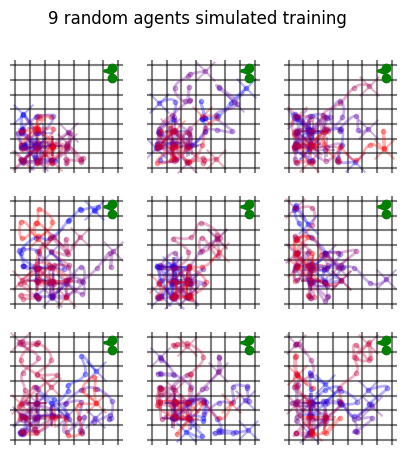

In [14]:
from agents import random_agent

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 random agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    random_agent_hyperparameters = None
    random_agent_constants = (9,)
    params_final,training_hist = run_loop(env,random_agent(random_agent_hyperparameters,random_agent_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


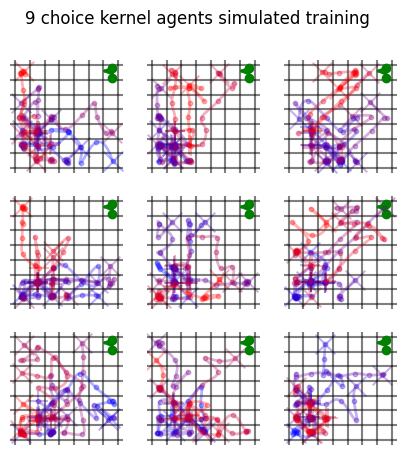

In [18]:
from agents import choice_kernel_agent


NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 choice kernel agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    ck_agent_hyperparameters = (0.5,3.0)
    # Learning rate x Action selection inverse temperature
    
    ck_agent_constants = (9,)

    params_final,training_hist = run_loop(env,choice_kernel_agent(ck_agent_hyperparameters,ck_agent_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


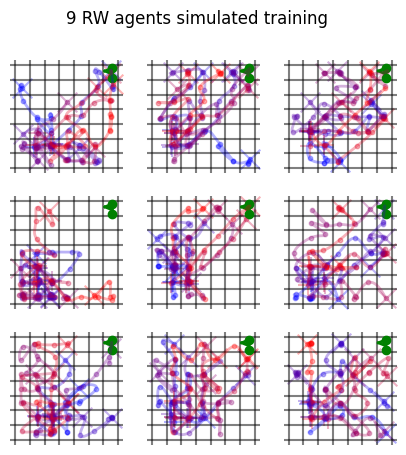

In [23]:
from agents import rescorla_wagner_agent

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 RW agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    rw_agent_hyperparameters = (0.5,10.0)
    rw_agent_constants = (9,)

    params_final,training_hist = run_loop(env,rescorla_wagner_agent(rw_agent_hyperparameters,rw_agent_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)








Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


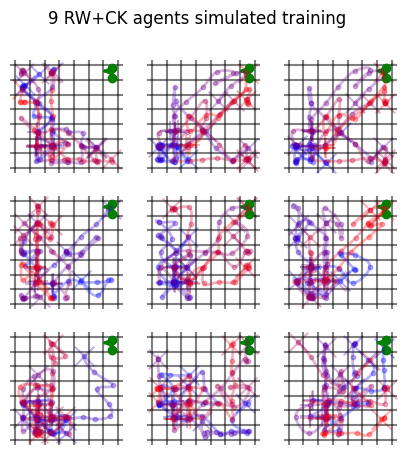

In [28]:
from agents import rw_ck_agent

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 RW+CK agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    rw_ck_agent_hyperparameters = (0.3,10.0,0.5,2.0)
    rw_ck_agent_constants = (9,)

    params_final,training_hist = run_loop(env,rw_ck_agent(rw_ck_agent_hyperparameters,rw_ck_agent_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial

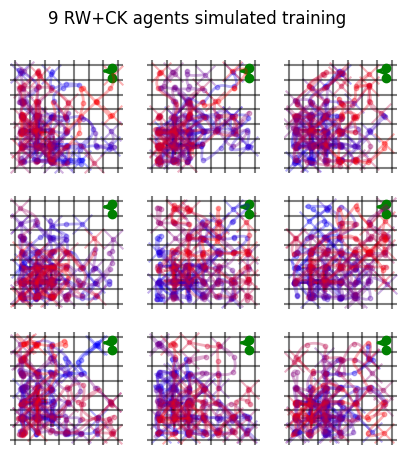

In [33]:
from agents import q_learning_agent

NTRIALS = 30
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 RW+CK agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    ql_ck_agent_hyperparameters = (0.9,0.9,10.0,0.0,0.0)
    ql_ck_agent_constants = (9,N_FEEDBACK_OUTCOMES)

    params_final,training_hist = run_loop(env,q_learning_agent(ql_ck_agent_hyperparameters,ql_ck_agent_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])
    # simulated_states = simulated_states[100:,...]

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

As expected with this very naive interpretation, this very basic Q-Learning agent struggle to generalize its findings to other stimuli fast enough. Depending on the initial parameters, this agent requires a lot of trials to reach the goal.

Several solutions exist for this issue. Active Inference proposes that subjects entertain one / several latent model(s) of the system, and learn the dynamics of the hidden states.

Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(1

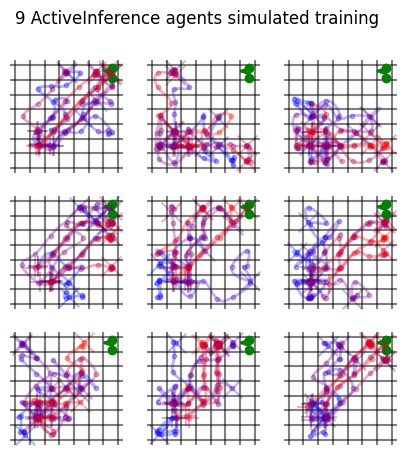

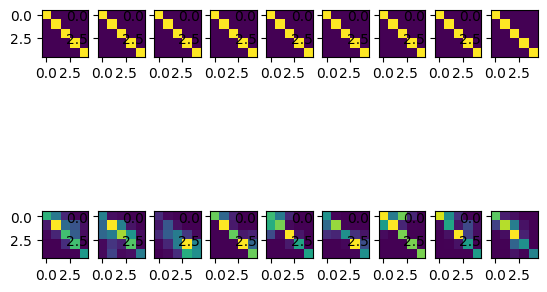

In [39]:
from agents import active_inference_basic_1D

# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions_distance" :3,
    "N_actions_position" :9,
    "N_actions_angle" :9,
    
    "Th" : 3
}

aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 10.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    
    "action_selection_temperature" : 10.0,
}

a0,b0,c0,d0,e0,u = basic_latent_model({**aif_1d_constants, **aif_1d_params})

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 ActiveInference agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(env,active_inference_basic_1D(aif_1d_params,aif_1d_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])
    # simulated_states = simulated_states[100:,...]

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


a,b,c,d,e,u = params_final
nu = u.shape[0]

fig,axs = plt.subplots(2,nu)
print(b)
for act in range(nu):
    ax = axs[0,act]
    ax.imshow(b0[0][...,act])
    
    ax = axs[1,act]
    ax.imshow(b[0][...,act])



Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(1

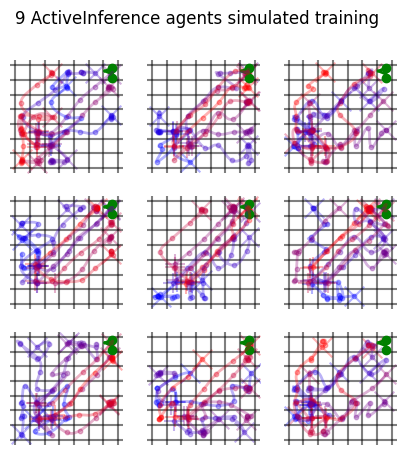

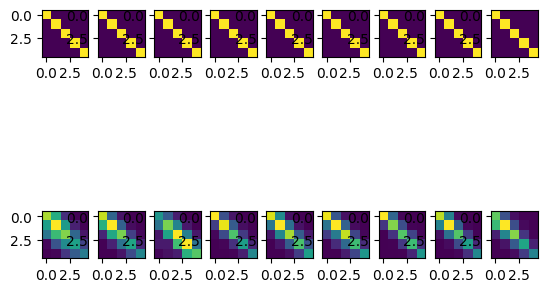

In [38]:
from agents import active_inference_basic_1D

# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions_distance" :3,
    "N_actions_position" :9,
    "N_actions_angle" :9,
    
    "Th" : 3
}

aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 0.5,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    
    "action_selection_temperature" : 10.0,
}

a0,b0,c0,d0,e0,u = basic_latent_model({**aif_1d_constants, **aif_1d_params})

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 ActiveInference agents simulated training")

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(env,active_inference_basic_1D(aif_1d_params,aif_1d_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])
    # simulated_states = simulated_states[100:,...]

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


a,b,c,d,e,u = params_final
nu = u.shape[0]

fig,axs = plt.subplots(2,nu)
print(b)
for act in range(nu):
    ax = axs[0,act]
    ax.imshow(b0[0][...,act])
    
    ax = axs[1,act]
    ax.imshow(b[0][...,act])



Nice, we have all of our proposal models.  However, we aim at performing model inversion based on task data ! This means that we're going to need **likelihood functions** for each of these models !

Likelihood function describe the probability of these models generating the observed actions, given their hyperparameters $\theta$ and their previous experiences $o_{1:T,1:t},s_{1:T,1:t}$ : 
$$
\sum_T \sum_{t\in T} P(u_t|o_{1:T,1:t},u_{1:T,1:t-1},\theta)
$$

In the next notebook, we'll derive these functions from the models shown here !